Wind-up voltage to: 0.450000 V
Wind-up voltage to: 0.400000 V
Wind-up voltage to: 0.350000 V
Wind-up voltage to: 0.300000 V
Wind-up voltage to: 0.250000 V
Wind-up voltage to: 0.200000 V
Wind-up voltage to: 0.150000 V
Wind-up voltage to: 0.100000 V
Wind-up voltage to: 0.050000 V
Wind-up voltage to: 0.000000 V
Final voltage set to: 0.000000 V


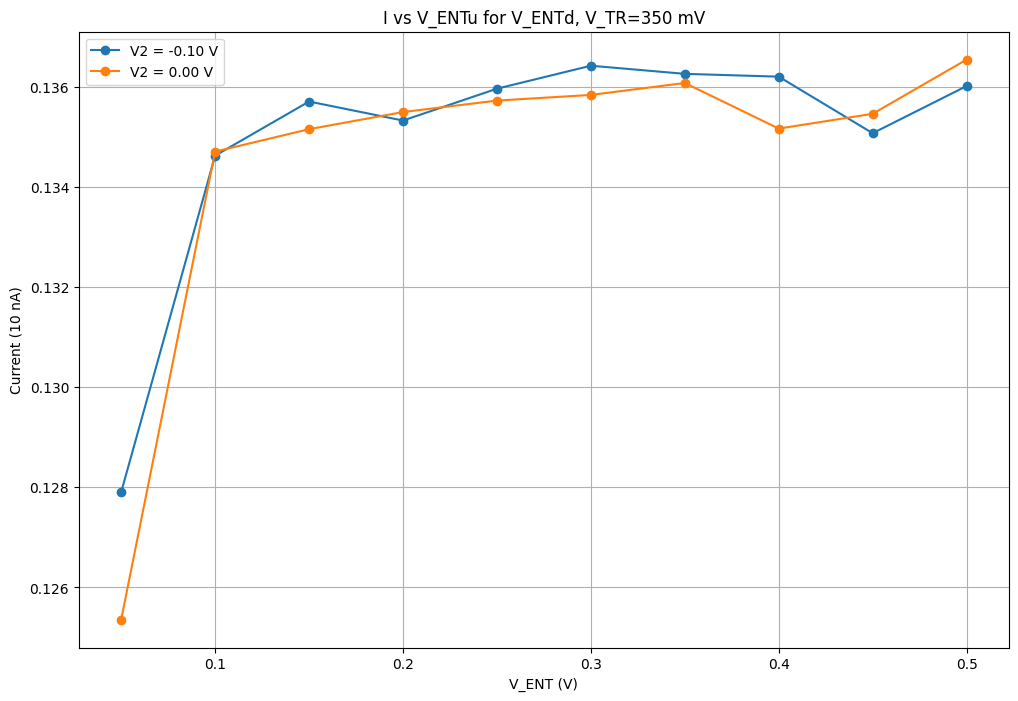

Target voltage: 0.000000 V
Multimeter: 0.125003 A
present voltage2: 0.000000 V
presnt frequency: 300000000.000000 Hz
present power: -10.000 dBM


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 19 21:16:20 2024

@author: Admin
"""

#!/usr/bin/env python
# coding: utf-8

#Claude ;double loop with sweeep function
#save file by IHLee

import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re  # Regular expressions module

# GPIB addresses
yokoid1 = "GPIB43::1::INSTR"
yokoid2 = "GPIB43::2::INSTR"
yokoid3 = "GPIB43::3::INSTR"
yokoid4 = "GPIB43::4::INSTR"
yokoid5 = "GPIB43::5::INSTR"
yokoid6 = "GPIB43::6::INSTR"
yokoid10 = "GPIB43::10::INSTR"
dmmid = "GPIB43::19::INSTR"
E4432B_address = "GPIB43::26::INSTR"

# Function to open resource
def open_resource(resource_id):
    rm = pyvisa.ResourceManager()
    return rm.open_resource(resource_id)

def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)

def append_multiple_lines(file_name, lines_to_append):
    with open(file_name, "a+") as file_object:
        appendEOL = False
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            appendEOL = True
        for line in lines_to_append:
            if appendEOL == True:
                file_object.write("\n")
            else:
                appendEOL = True
            file_object.write(line)

# RF Functions
def present_freq(instrument):
    try:
        response = instrument.query("FREQ?")  # Note the '?' to query the value
        match = re.search(r'([+-]?\d+\.?\d*E?[+-]?\d*)', response)
        if match:
            return float(match.group(1))
        else:
            raise ValueError(f"Unexpected response format: {response}")
    except Exception as e:
        print(f"Error retrieving freq: {e}")
        return None

def windup_freq(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_freq(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        instrument.write(f'FREQ {new_voltage}')
        print(f"Wind-up freq to: {new_voltage:.3f} Hz")
        time.sleep(delay)
        present_voltage_val = present_freq(instrument)
    instrument.write(f'FREQ {start_voltage}')
    print(f"Final freq set to: {start_voltage:.3f} Hz")

def present_Prf(instrument):
    try:
        response = instrument.query("POW?")  # Note the '?' to query the value
        match = re.search(r'([+-]?\d+\.?\d*E?[+-]?\d*)', response)
        if match:
            return float(match.group(1))
        else:
            raise ValueError(f"Unexpected response format: {response}")
    except Exception as e:
        print(f"Error retrieving power: {e}")
        return None

def windup_Prf(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_Prf(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        instrument.write(f'POW {new_voltage}')
        print(f"Wind-up power to: {new_voltage:.3f} dBm")
        time.sleep(delay)
        present_voltage_val = present_Prf(instrument)
    instrument.write(f'POW {start_voltage}')
    print(f"Final voltage set to: {start_voltage:.3f} dBm")

# Function to read present voltage
def present_voltage(instrument):
    response = instrument.query("OD")
    match = re.search(r'([+-]?\d+\.\d+E[+-]\d+)', response)
    if match:
        return float(match.group(1))
    else:
        raise ValueError(f"Unexpected response format: {response}")

# Function to wind up voltage
def windup_voltage(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_voltage(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Wind-up voltage to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)
    instrument.write(f"S{start_voltage:.6f}E")
    print(f"Final voltage set to: {start_voltage:.6f} V")

#modified from the original to save data
def sweep_V1(instrument, start_voltage, target_voltage, step_size, delay):
    present_voltage_val = start_voltage
    currents, voltages = [], []
    step_size = abs(step_size) if present_voltage_val < target_voltage else -abs(step_size)
    while abs(present_voltage_val - target_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = target_voltage if (step_size > 0 and new_voltage > target_voltage) or (step_size < 0 and new_voltage < target_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Sweeping voltage to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)
        voltages.append(present_voltage_val)
        dmm = open_resource(dmmid)
        current = float(dmm.query("fetch?"))
        currents.append(current)
       
        print(f"Multimeter: {current:.6f} A")
        plt.figure(figsize=(10, 6))
        plt.plot(voltages, currents, 'b-o', label='Current vs Voltage')  # Added label here
        plt.title("Current vs Voltage")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")
        plt.grid(True)
        plt.legend()  # Now this will work because we have a label
        plt.show()
        plt.close()
        clear_output(wait=True)
        time.sleep(0.2)
    return voltages, currents

def sweep_V2(instrument, start_voltage, target_voltage, step_size, delay):
    present_voltage_val = start_voltage
    step_size = abs(step_size) if present_voltage_val < target_voltage else -abs(step_size)
    while abs(present_voltage_val - target_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = target_voltage if (step_size > 0 and new_voltage > target_voltage) or (step_size < 0 and new_voltage < target_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Setting V2 to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)
    
def sweep_V1_for_fixed_V2(instrument1, instrument2, V1_start, V1_end, V1_step, V2_value, delay):
    sweep_V2(instrument2, present_voltage(instrument2), V2_value, V1_step, delay)
    print(f"V2 fixed at: {V2_value:.6f} V")
    return sweep_V1(instrument1, V1_start, V1_end, V1_step, delay)

def main():
    instrument1 = open_resource(yokoid4) 
    instrument2 = open_resource(yokoid10) 
    instrument3 = open_resource(yokoid2) 
    instrument4 = open_resource(yokoid3) 
    instrument5 = open_resource(yokoid1) 
    instrument6 = open_resource(yokoid5) 
    instrument7 = open_resource(yokoid6)
    instrument = open_resource(E4432B_address) #rf source
    
    start_voltage1, step_size1, delay1 = 0.0, 0.05, 0.2 #ENT
    start_voltage2, step_size2, delay2 = -0.1, 0.05, 0.2 #TR
    start_voltage3, step_size3, delay3 = 0.0, 0.05, 0.05 #Vsd
    start_voltage4, step_size4, delay4 = 0.0, 0.05, 0.05 #pl
    start_voltage5, step_size5, delay5 = 0.0, 0.05, 0.05 #ext
    start_voltage6, step_size6, delay6 = 0.0, 0.05, 0.05 #ext
    start_voltage7, step_size7, delay7 = 0.0, 0.05, 0.05 #ext
    start_voltage8, step_size5, delay5 = -10, 0.2, 0.2  #instrument  #Prf
    start_voltage9, step_size6, delay6 = 3e8, 1e7, 0.2  #instrument  #freq
 
    target_voltage1, step_size0, delay0 = 0.5, 0.1, 0.2  #ENT
    target_voltage2, step_size02, delay02 = 0.1, 0.1, 0.2 #TR
    
    windup_voltage(instrument1, start_voltage1, step_size1, delay1) #ENT
    windup_voltage(instrument2, start_voltage2, step_size2, delay2) #TR
    windup_voltage(instrument3, start_voltage3, step_size3, delay3) #TR
    windup_voltage(instrument4, start_voltage4, step_size4, delay4) #trench
    windup_voltage(instrument5, start_voltage5, step_size5, delay5) #pl
    windup_voltage(instrument6, start_voltage6, step_size6, delay6) #EXT
    windup_voltage(instrument7, start_voltage7, step_size7, delay7) #TR
    windup_Prf(instrument, start_voltage8, step_size5, delay5) #Prf
    windup_freq(instrument, start_voltage9, step_size6, delay6)#freq
    
    voltage1 = present_voltage(instrument1)
    voltage2 = present_voltage(instrument2)
    voltage5 = present_Prf(instrument)
    voltage6 = present_freq(instrument)
    
    print(f"Starter voltage1: {voltage1:.6f} V")
    print(f"Starter voltage2: {voltage2:.6f} V")
    print(f"Starter voltage5: {voltage5:.6f} Hz")
    print(f"Starter voltage6: {voltage6:.3f} dBM")
   
    # FIXED: Corrected the step direction for V2_values
    # Since we're going from -0.1 to 0.1, we need a POSITIVE step
    V2_values = np.arange(start_voltage2, target_voltage2, step_size02)
    
    print(f"V2_values will be: {V2_values}")  # Debug print to show the values
    
    all_results = []
    print(f"Initial all_results: {all_results}")
        
    for V2 in V2_values:
        print(f"\nSweeping V1 with V2 fixed at {V2:.2f} V")
        voltages, currents = sweep_V1_for_fixed_V2(instrument1, instrument2, start_voltage1, target_voltage1, step_size1, V2, delay1)
        windup_voltage(instrument1, start_voltage1, step_size1, delay1)
        all_results.append((V2, voltages, currents))

    # Save data to file
    fname = 'test_20250908-data_IVentu-Ventd-0Vsd_tr0_XX.txt'
    lines_to_append = []
    for V2, voltages, currents in all_results:
        for v, i in zip(voltages, currents):
            line = f"{V2:.6f} {v:.6f} {i:.6f}"
            lines_to_append.append(line)
    append_multiple_lines(fname, lines_to_append)
    
    # Plot all results - FIXED: Only call legend if we have labeled plots
    plt.figure(figsize=(12, 8))
    if all_results:  # Only plot if we have results
        for V2, voltages, currents in all_results:
            plt.plot(voltages, currents, '-o', label=f'V2 = {V2:.2f} V')
        
        plt.title("I vs V_ENTu for V_ENTd, V_TR=350 mV")
        plt.xlabel("V_ENT (V)")
        plt.ylabel("Current (10 nA)")
        plt.legend()  # Now this will work because we have labels
        plt.grid(True)
        plt.show()
    else:
        print("No data to plot")
    
    voltage_target = present_voltage(instrument1)
    print(f"Target voltage: {voltage_target:.6f} V")
    dmm = open_resource(dmmid)
    current = float(dmm.query("fetch?"))
    print(f"Multimeter: {current:.6f} A")
    voltage2 = present_voltage(instrument2)
    print(f"present voltage2: {voltage2:.6f} V")
    
    voltage5=present_freq(instrument)
    voltage6=present_Prf(instrument)
    print(f"presnt frequency: {voltage5:.6f} Hz")
    print(f"present power: {voltage6:.3f} dBM")

if __name__ == "__main__":
    main()